In [124]:
from IPython.display import Markdown, Latex, display
import datetime
import pandas as pd
import geopandas as gpd

In [125]:
import rasterio
import shapely
from rasterio.features import shapes
from rasterio.mask import mask

def get_load_gdf(vuelo, z):
    carga = {1: 1.5, 2:7.5, 3: 5, 4: 30, 5: 7, 6: 12.5, 7: 12.5, 9: 8}
    ds = rasterio.open(f'FINALES/FM/fm_{vuelo}_zona{z}.tif')
    s = shapes(rasterio.band(ds, 1))
    
    g = list(s)
    
    geom = [shapely.geometry.shape(i[0]) for i in g]
    geom = gpd.GeoSeries(geom, crs=ds.crs)
    geom
    
    values = [int(i[1]) for i in g]
    values = pd.Series(values)
    
    result = gpd.GeoDataFrame({'vuelo': vuelo, 'modelo': values, 'geometry': geom})
    result = result[result.modelo > 0]
    
    result['area'] = result.apply(lambda x: x.geometry.area / 10_000, axis=1)
    result = result[['modelo', 'vuelo', 'area']].groupby(['modelo', 'vuelo']).sum().reset_index()
    result['carga'] = result.apply(lambda x: x.area * carga[x.modelo], axis=1)
    
    return result

In [126]:
vuelos_texto = {
    'lida2': 'IGN2017',
    'lida3': 'IGN2024',
    'vuelo1': 'Vuelo1',
    'vuelo2': 'Vuelo2'}

In [127]:
fechas_vuelos = {'lida2': datetime.datetime(2017, 10, 10), 
          'vuelo1': datetime.datetime(2024, 8, 23),  
          'lida3': datetime.datetime(2024, 9, 1), 
          'vuelo2': datetime.datetime(2025, 10, 2)}

In [128]:
fechas_vuelos_z3 = {'lida2': datetime.datetime(2017, 10, 10), 
          'lida3': datetime.datetime(2024, 9, 1), 
          'vuelo2': datetime.datetime(2025, 10, 2)}

# SITUACIÓN

Las parcelas de estudio se encuentran localizadas en la cara sur de la sierra de Leyre dentro del municipio de Yesa. Se muestra un mapa con la distrbución de la vegetación:

In [129]:
display('', metadata={
    'tipo': 'imagen',
    'nombre': 'ocupacion_suelo',
    'caption': 'Mapa de vegetación en las parcelas de estudio. Fuente: elaboración propia a partir de datos obtenidos del IDENA'
})

''

En el año 2022 parte de la zona de estudio se vio afectada por un incendio forestal ocurrido el 15 de junio de ese año. Se muestra un mapa de las zonas afectadas por el incendio. La escala de colores representa el grado de severidad del incendio

In [130]:
display('', metadata={
    'tipo': 'imagen',
    'nombre': 'dNBR',
    'caption': 'Zonas afectadas por el incendio forestal del 2022. Fuente: elaboración propia a partir de imágenes multiespectrales del satélite Sentinel2'
})

''

Se puede observar que el incendio afectó principalmente a la zona 2, pero la severidad del mismo no fue homogénea en todo su territorio. Se muestra detalle de la severidad en esa zona y como se observa una "isla" de color verde en el que el incendio tuvo menos intesidad.

In [131]:
display('', metadata={
    'tipo': 'imagen',
    'nombre': 'dNBR_zona2',
    'caption': 'Detalle de la serveridad del incendio en la zona 2. Fuente: elaboración propia a partir de imágenes multiespectrales del satélite Sentinel2'
})

''

# FUENTE DE DATOS Y METODOLOGÍA

Para describir la evolución de la vegetación de los últimos años y observar la afectación de la carga ganadera, los desbroces y el incendio de 2022 se cuentan con 4 fuentes de datos LIDAR:

- Vuelo del Plan Nacional de Ortofotografía Aerea (PNOA) del Instituto Geográfico Nacional realizado en el año 2017 con una resolución de 17 puntos / m². A partir de ahora estos datos se nombrarán como IGN2017
- Vuelo del Plan Nacional de Ortofotografía Aerea (PNOA) del Instituto Geográfico Nacional realizado en el año 2024 con una resolución de 5 puntos / m². A partir de ahora estos datos se nombrarán como IGN2024
- Vuelo de agosto de 2024 con una resolución aproximada de 200 puntos / m². A partir de ahora estos datos se nombrarán como Vuelo1
- Vuelo de octubre de 2024 con una resolución aproimada de 200 puntos / m². A partir de ahora estos datos se nombrarán como Vuelo2

Se han utilizado dos métodos para calcular biomasa a partir de datos LIDAR:

- Método basado en los modelos de combustible de Rothermel.
- Fórmula alométrica.

# RESULTADOS 

## Método de Rothermel.

### Zona 1

In [132]:
z = 1
textos = {
    'lida2': 'Se observa predominio de modelo 4, es decir, un matorral alto y denso con gran capacidad de propagar incendios forestales y al que Rothermel le asigna un valor alto de biomasa por unidad de superficie',
    'lida3': 'Similar a los datos del vuelo IGN2024, pero se observa un repunte de retornos en capas bajas de vegetación.',
    'vuelo1': 'Se observa una disminución en en el modelo 4 y una aumento de los modelos de pasto 1 y 2, este cambio en la carga de combustible es probable que se deba a los desbroces ejecutados en la zona',
    'vuelo2': 'Se observa un ligero aumento en el porcentage de modelos de matorral (5 y 6) y una disminución de los modelos de pasto, esto puede indicar que la carga ganadera no es lo suficientemente alta para mantener el desbroce realizado en 2024'
}

gdf = {}
carga = {}
for i in list(textos.keys()):
    a = get_load_gdf(i, z)
    a.loc['Total', ['area', 'carga']] = a.sum(numeric_only=True, axis=0)

    gdf[i] = a[['modelo', 'area', 'carga']].to_latex(index=False, formatters={'carga': '{:.2f}', 'area': '{:.2f}', 'modelo': '{:.0f}'}, na_rep='Total', column_format='ccc')
    carga[i] = a.loc['Total', 'carga']
    
display('', metadata={'tipo': 'descripcion', 'datos': {
                        'zona': z, 
                        'vuelos': ['lida2', 'vuelo1', 'lida3', 'vuelo2'], 
                        'textos': textos,
                        'gdf': gdf,
                        'carga': carga}})

''

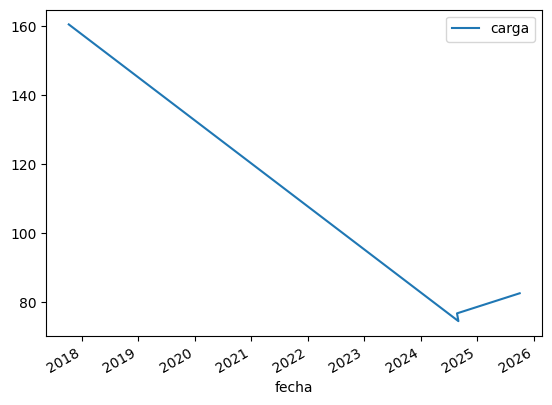

In [133]:
carga_df = pd.DataFrame({'carga': [carga[x] for x in list(textos.keys())], 'fecha': [fechas_vuelos[x] for x in list(textos.keys())]})

fig = carga_df.plot(x='fecha')

### Zona 2

In [134]:
z = 2
textos = {
    'lida2': 'Predominio casi total de modelo 7. Es decir un modelo de matorral bajo arbolado con continuidad vertical. Rothermel le asigna cargas de biomasa por unidad de superficie medias pues considera que es el matorral, principalmente, el que va a propagar el fuego',
    'lida3': 'Similar a los datos de IGN2024, también se observa en el histograma un aumento de retornos en capas bajas de vegetación',
    'vuelo1': 'Debido al incendio de 2022 se observa una disminución drástica en la vegetación lo que se traduce en disminución de modelo 7 y aumento de los modelos de combustible de tipo matorral',
    'vuelo2': 'El incremento de retornos en capas bajas de vegetación en el histograma es más evidente que en el año anterior, pudiendo indicar que la carga ganadera es demasiado baja'
}

gdf = {}
carga = {}
for i in list(textos.keys()):
    a = get_load_gdf(i, z)
    a.loc['Total', ['area', 'carga']] = a.sum(numeric_only=True, axis=0)

    gdf[i] = a[['modelo', 'area', 'carga']].to_latex(index=False, formatters={'carga': '{:.2f}', 'area': '{:.2f}', 'modelo': '{:.0f}'}, na_rep='Total', column_format='ccc')
    carga[i] = a.loc['Total', 'carga']
    
display('', metadata={'tipo': 'descripcion', 'datos': {
                        'zona': z, 
                        'vuelos': ['lida2', 'lida3', 'vuelo2'], 
                        'textos': textos,
                        'gdf': gdf,
                        'carga': carga}})

''

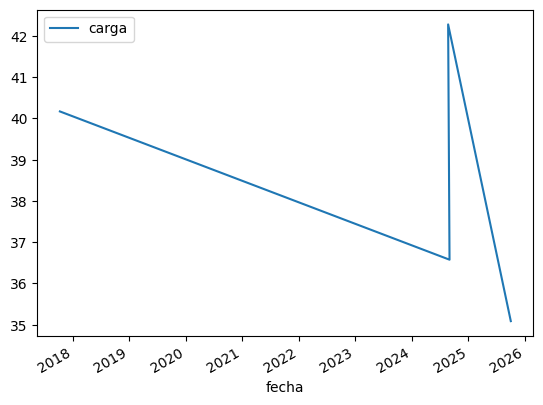

In [135]:
carga_df = pd.DataFrame({'carga': [carga[x] for x in list(textos.keys())], 'fecha': [fechas_vuelos[x] for x in list(textos.keys())]})

fig = carga_df.plot(x='fecha')

### Zona 3

In [136]:
z = 3
textos = {
    'lida2': 'Zona muy inflamable con presencia alta de 2 de los modelos más desfavorables para la propagación de un incendio forestal, el modelo 4 y el model 7',
    'lida3': 'En los mapas de vegetación se muestra una disminución de la misma en dos zonas muy concretas de la parcela: zona sur debido a desbroces realizados en 2024 y zona norte debido al incendio forestal de 2022. Eso se traduce en el aumento de modelos de combustible menos favorables para la propagación de un incendio forestal, como los modelos de pasto 1 y 2 y el modelo de matorral de tipo 6',
    'vuelo2': 'Se observa ligero repunte de retorno de capas bajas de vegetación en el histograma'
}

gdf = {}
carga = {}
for i in list(textos.keys()):
    a = get_load_gdf(i, z)
    a.loc['Total', ['area', 'carga']] = a.sum(numeric_only=True, axis=0)

    gdf[i] = a[['modelo', 'area', 'carga']].to_latex(index=False, formatters={'carga': '{:.2f}', 'area': '{:.2f}', 'modelo': '{:.0f}'}, na_rep='Total', column_format='ccc')
    carga[i] = a.loc['Total', 'carga']
    
display('', metadata={'tipo': 'descripcion', 'datos': {
                        'zona': z, 
                        'vuelos': ['lida2', 'vuelo1', 'lida3', 'vuelo2'], 
                        'textos': textos,
                        'gdf': gdf,
                        'carga': carga}})

''

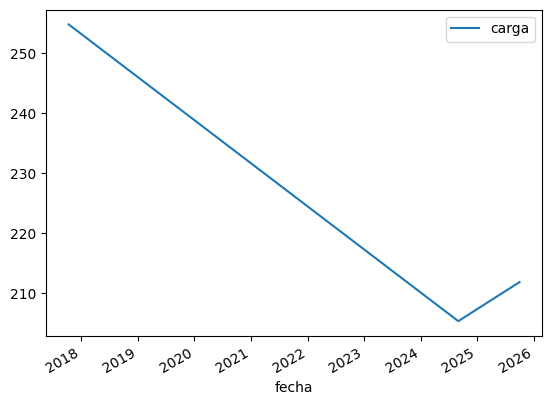

In [137]:
carga_df = pd.DataFrame({'carga': [carga[x] for x in list(textos.keys())], 'fecha': [fechas_vuelos[x] for x in list(textos.keys())]})

fig = carga_df.plot(x='fecha')

## FÓRMULA ALOMÉTRICA

In [138]:
vuelos = {'IGN2017': datetime.datetime(2017, 10, 10), 
          'IGN2024': datetime.datetime(2024, 9, 1), 
          'Vuelo1': datetime.datetime(2024, 8, 23),
          'Vuelo2': datetime.datetime(2025, 10, 2)}

\pagebreak

# ZONA 1

In [139]:
import datetime
from IPython.display import Markdown, Latex, display
import pandas as pd
import geopandas as gpd

z = 1

display('', metadata={'tipo': 'biomasa', 'datos': {'zona': z, 'vuelos': ['lida2', 'lida3', 'vuelo1', 'vuelo2']}})

''

\pagebreak

\begin{tabular}{llr}
\toprule
vuelo & fecha & biomasa \\
\midrule
IGN2017 & 10/10/2017 & 721.494451 \\
IGN2024 & 01/09/2024 & 405.765869 \\
Vuelo1 & 23/08/2024 & 932.085686 \\
Vuelo2 & 02/10/2025 & 963.986991 \\
\bottomrule
\end{tabular}


<Axes: xlabel='fecha'>

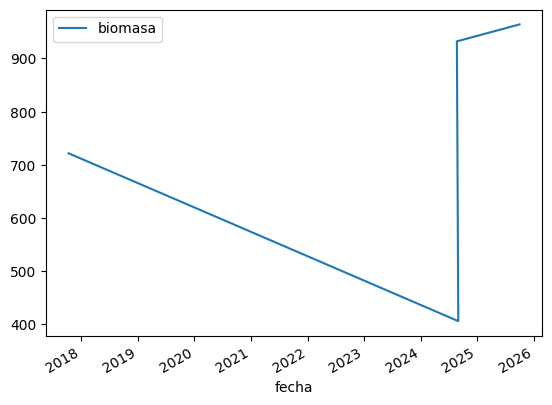

In [140]:
biomasa = []

for vuelo in ['lida2', 'lida3', 'vuelo1', 'vuelo2']:
    gdf = gpd.read_file(f'BIOMASA/SHP/{vuelo.upper()}_ZONA{z}')
    biomasa.append(gdf['agb'].sum())

df = pd.DataFrame({'vuelo': vuelos.keys(), 'fecha': vuelos.values(), 'biomasa': biomasa})

display(Markdown(df.to_latex(index=False, formatters={'fecha': '{:%d/%m/%Y}'})))
df.plot(x='fecha')

\pagebreak

# ZONA 2

In [141]:
import datetime
from IPython.display import Markdown, Latex, display
import pandas as pd
import geopandas as gpd

z = 2

display('', metadata={'tipo': 'biomasa', 'datos': {'zona': z, 'vuelos': ['lida2', 'lida3', 'vuelo1', 'vuelo2']}})

''

\pagebreak

\begin{tabular}{llr}
\toprule
vuelo & fecha & biomasa \\
\midrule
IGN2017 & 10/10/2017 & 1622.772387 \\
IGN2024 & 01/09/2024 & 976.839774 \\
Vuelo1 & 23/08/2024 & 755.679450 \\
Vuelo2 & 02/10/2025 & 684.656454 \\
\bottomrule
\end{tabular}


<Axes: xlabel='fecha'>

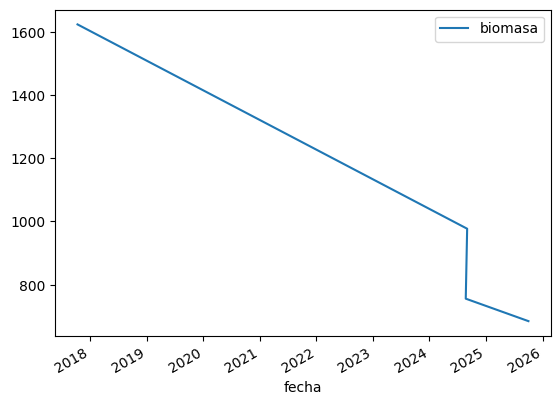

In [142]:
biomasa = []

for vuelo in ['lida2', 'lida3', 'vuelo1', 'vuelo2']:
    gdf = gpd.read_file(f'BIOMASA/SHP/{vuelo.upper()}_ZONA{z}')
    biomasa.append(gdf['agb'].sum())

df = pd.DataFrame({'vuelo': vuelos.keys(), 'fecha': vuelos.values(), 'biomasa': biomasa})

display(Markdown(df.to_latex(index=False, formatters={'fecha': '{:%d/%m/%Y}'})))
df.plot(x='fecha')

\pagebreak

# ZONA 3

In [143]:
vuelos_z3 = {'IGN2017': datetime.datetime(2017, 10, 10), 
          'IGN2024': datetime.datetime(2024, 9, 1), 
          'vuelo2': datetime.datetime(2025, 10, 2)}

In [144]:
z = 3

display('', metadata={'tipo': 'biomasa', 'datos': {'zona': z, 'vuelos': ['lida2', 'lida3', 'vuelo2']}})

''

\pagebreak

\begin{tabular}{llr}
\toprule
vuelo & fecha & biomasa \\
\midrule
IGN2017 & 10/10/2017 & 2972.461342 \\
IGN2024 & 01/09/2024 & 1537.545626 \\
vuelo2 & 02/10/2025 & 3191.530950 \\
\bottomrule
\end{tabular}


<Axes: xlabel='fecha'>

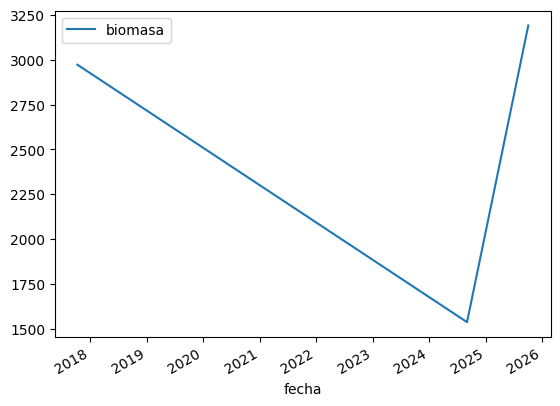

In [145]:
biomasa = []

for vuelo in ['lida2', 'lida3', 'vuelo2']:
    gdf = gpd.read_file(f'BIOMASA/SHP/{vuelo.upper()}_ZONA{z}')
    biomasa.append(gdf['agb'].sum())

df = pd.DataFrame({'vuelo': vuelos_z3.keys(), 'fecha': vuelos_z3.values(), 'biomasa': biomasa})

display(Markdown(df.to_latex(index=False, formatters={'fecha': '{:%d/%m/%Y}'})))
df.plot(x='fecha')

# CONCLUSIONES

## ZONA 2